In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit



C:\Users\pc\AppData\Local\Temp\ipykernel_2624\3842574039.py:48: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sns.heatmap(pivot_clusters.replace({"Low": 0, "Medium": 1, "High": 2}), cmap="Set2", annot=pivot_clusters, fmt="", cbar_kws={"label": "Cluster"})


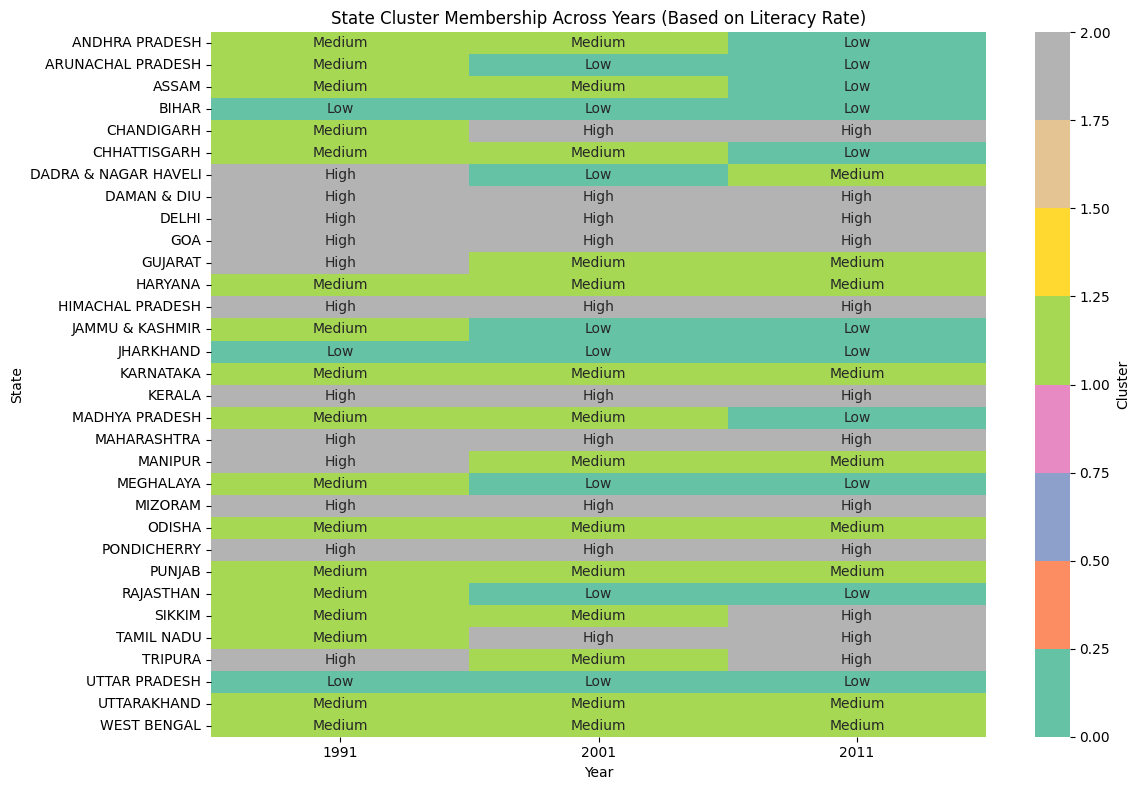

In [11]:
# -----------------------------
# 1. Load and preprocess data
# -----------------------------
file_path = "D:\How_Educated_India\Datasets\All_Ages_And_Total_Area_Data.csv"  # Update path if needed
df = pd.read_csv(file_path)

# Compute Literacy Rate
# Avoid division by zero by replacing with NaN when Total Person = 0
df["Literacy Rate"] = (df["Literate Person"] / df["Total Person"]) * 100

# Group by State and Year
state_year_lit = df.groupby(["State Name", "Year"], as_index=False)["Literacy Rate"].mean()

# -----------------------------
# 2. Apply KMeans clustering per year
# -----------------------------
clustered_data = []

for year, group in state_year_lit.groupby("Year"):
    X = group[["Literacy Rate"]].values
    
    # Fit KMeans with 3 clusters
    kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
    group["Cluster"] = kmeans.fit_predict(X)
    
    # Manually assign cluster labels (Low, Medium, High) based on average literacy in each cluster
    cluster_means = group.groupby("Cluster")["Literacy Rate"].mean().sort_values()
    cluster_mapping = {cluster_means.index[0]: "Low", 
                       cluster_means.index[1]: "Medium", 
                       cluster_means.index[2]: "High"}
    
    group["Cluster Label"] = group["Cluster"].map(cluster_mapping)
    clustered_data.append(group)

# Combine results
clustered_df = pd.concat(clustered_data)

# -----------------------------
# 3. Compare clusters across years
# -----------------------------
pivot_clusters = clustered_df.pivot(index="State Name", columns="Year", values="Cluster Label")

# -----------------------------
# 4. Visualization
# -----------------------------
# Heatmap to see if states stay in same cluster or change
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_clusters.replace({"Low": 0, "Medium": 1, "High": 2}), cmap="Set2", annot=pivot_clusters, fmt="", cbar_kws={"label": "Cluster"})
plt.title("State Cluster Membership Across Years (Based on Literacy Rate)")
plt.ylabel("State")
plt.xlabel("Year")
plt.tight_layout()
plt.show()




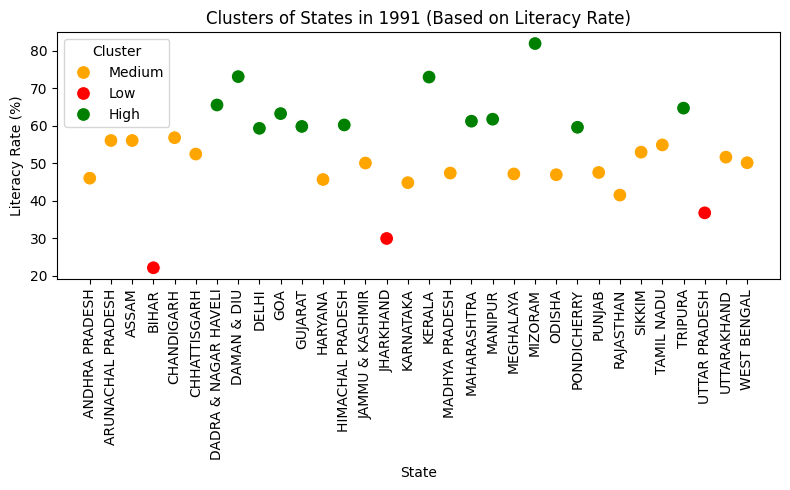

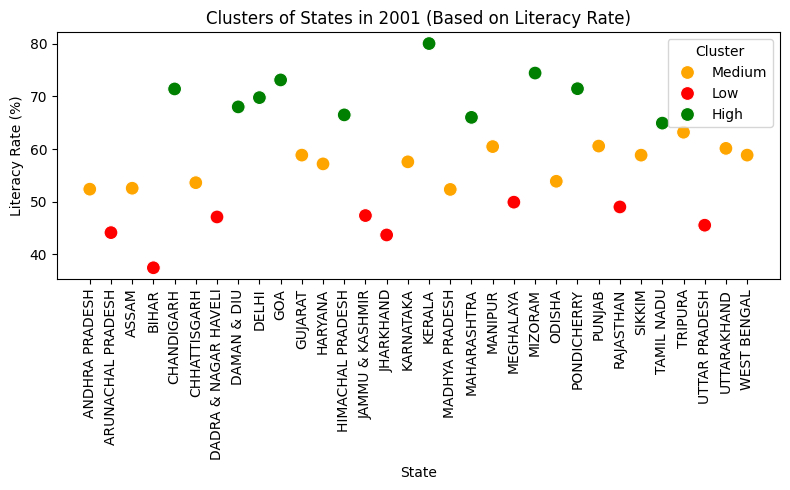

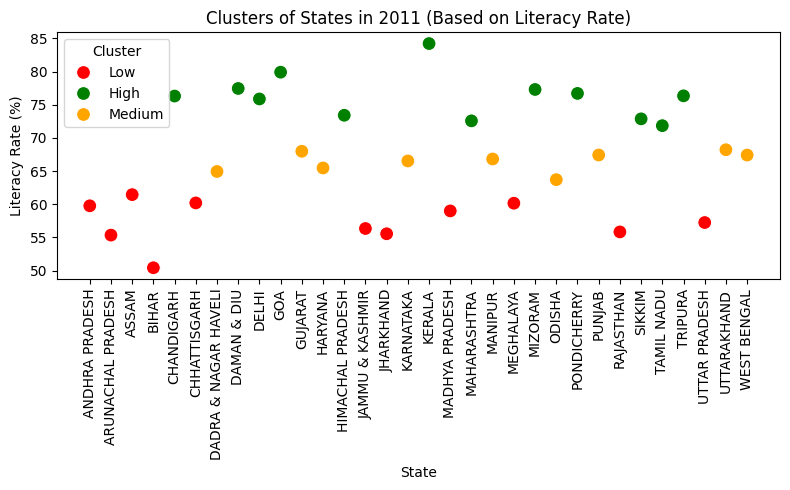

In [12]:
# Scatter plot for each year
for year, group in clustered_df.groupby("Year"):
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=group["State Name"], y=group["Literacy Rate"], hue=group["Cluster Label"], palette={"Low":"red", "Medium":"orange", "High":"green"}, s=100)
    plt.xticks(rotation=90)
    plt.title(f"Clusters of States in {year} (Based on Literacy Rate)")
    plt.ylabel("Literacy Rate (%)")
    plt.xlabel("State")
    plt.legend(title="Cluster")
    plt.tight_layout()
    plt.show()

C:\Users\pc\AppData\Local\Temp\ipykernel_2624\3688824683.py:36: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(logistic, years.flatten(), rates,


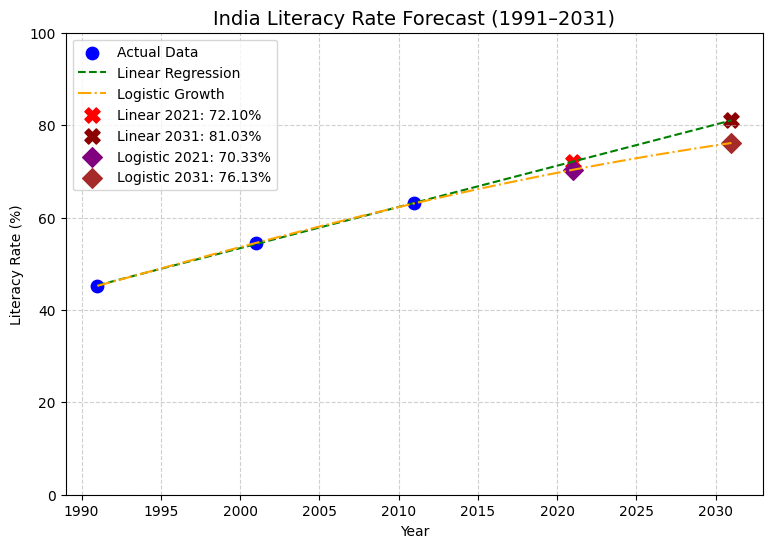

Forecasts:
Linear → 2021: 72.10%, 2031: 81.03%
Logistic → 2021: 70.33%, 2031: 76.13%


In [13]:


# Load dataset

df.columns = [c.strip() for c in df.columns]

# Filter for national totals (Area=Total, Age=All, Distt Code=0)
df_f = df.copy()
if "Area" in df_f.columns:
    df_f = df_f[df_f["Area"].astype(str).str.lower().str.strip() == "total"]
if "Age" in df_f.columns:
    df_f = df_f[df_f["Age"].astype(str).str.lower().str.contains("all")]
if "Distt Code" in df_f.columns:
    try:
        df_f = df_f[df_f["Distt Code"].astype(int) == 0]
    except Exception:
        df_f = df_f[df_f["Distt Code"].astype(str).str.strip() == "0"]

df_f["Total Person"] = pd.to_numeric(df_f["Total Person"], errors="coerce")
df_f["Literate Person"] = pd.to_numeric(df_f["Literate Person"], errors="coerce")

# Aggregate nationally
national = df_f.groupby("Year")[["Total Person","Literate Person"]].sum().reset_index().sort_values("Year")
national["Literacy Rate"] = national["Literate Person"] / national["Total Person"] * 100

# --- Linear Regression ---
years = national["Year"].astype(int).values.reshape(-1,1)
rates = national["Literacy Rate"].values
lin = LinearRegression().fit(years, rates)
pred_2021_lin = lin.predict(np.array([[2021]]))[0]
pred_2031_lin = lin.predict(np.array([[2031]]))[0]

# --- Logistic Growth Model ---
def logistic(x, L ,k, x0):
    return L / (1 + np.exp(-k*(x-x0)))

# Fit logistic model (with bounds so L ≤ 100)
params, _ = curve_fit(logistic, years.flatten(), rates, 
                      p0=[100, 0.05, 2000], bounds=([70,0,1900],[100,1,2100]))
L, k, x0 = params
pred_2021_log = logistic(2021, L, k, x0)
pred_2031_log = logistic(2031, L, k, x0)

# --- Visualization ---
plt.figure(figsize=(9,6))

# Actual data points
plt.scatter(national["Year"], national["Literacy Rate"], color="blue", s=80, label="Actual Data")

# Linear regression line
year_range = np.arange(1991, 2031+1).reshape(-1,1)
plt.plot(year_range, lin.predict(year_range), color="green", linestyle="--", label="Linear Regression")

# Logistic growth curve
plt.plot(year_range, logistic(year_range.flatten(), L, k, x0), color="orange", linestyle="-.", label="Logistic Growth")

# Forecast points
plt.scatter([2021], [pred_2021_lin], color="red", marker="X", s=120,
            label=f"Linear 2021: {pred_2021_lin:.2f}%")
plt.scatter([2031], [pred_2031_lin], color="darkred", marker="X", s=120,
            label=f"Linear 2031: {pred_2031_lin:.2f}%")

plt.scatter([2021], [pred_2021_log], color="purple", marker="D", s=100,
            label=f"Logistic 2021: {pred_2021_log:.2f}%")
plt.scatter([2031], [pred_2031_log], color="brown", marker="D", s=100,
            label=f"Logistic 2031: {pred_2031_log:.2f}%")

plt.title("India Literacy Rate Forecast (1991–2031)", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Literacy Rate (%)")
plt.ylim(0, 100)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()

# --- Print results ---
print("Forecasts:")
print(f"Linear → 2021: {pred_2021_lin:.2f}%, 2031: {pred_2031_lin:.2f}%")
print(f"Logistic → 2021: {pred_2021_log:.2f}%, 2031: {pred_2031_log:.2f}%")
